# DSC 40A - Gradient Descent

In this notebook, we'll see gradient descent in action. This demo is intended to be a *supplement* to lecture; in particular, you won't be expected to code up gradient descent. In addition, the code in this notebook is not designed to be *fast*, but instead *easy to understand*. Remember: the focus of DSC 40A is more on the math than the code.

We'll get started by importing the familiar Python numerical and plotting packages, `numpy` and `matplotlib`.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
import ipywidgets

plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [12, 8]
mpl.rcParams['animation.html'] = 'jshtml'

## 1. Code for Gradient Descent

First, we'll code up a general gradient descent function. The code below implements gradient descent as seen in lecture:

In [2]:
def gradient_descent(
        derivative_of_f, *, h_0, alpha, max_iter=10_000, tol=1e-12, verbose=False,
        callback=None
    ):
    """Minimize a (univariate) function f using gradient descent.
    
    Parameters
    ----------
    derivative_of_f : callable
        A function which accepts one argument, h, and outputs the derivative
        of f at h.
    h_0 : float
        The initial guess of the minimizer.
    alpha : float
        The step size parameter.
    max_iter : int
        The maximum number of steps to take.
    tol : float
        The convergence tolerance. If the difference between subsequent guesses
        is less than tol, the algorithm will assume that it has converged.
    verbose : bool
        If `True`, prints the progress of the search.
    callback : callable
        A function called after every update with the new position.
    """
    h = h_0
    for iteration in range(max_iter):
        h_next = h - alpha * derivative_of_f(h)
        if np.abs(h_next - h) < tol:
            break
        if verbose:
            print(f'iter #{iteration}: h={h_next}')
        if callback is not None:
            callback(h_next)
        h = h_next
    else:
        if verbose:
            print('Reached Max Iters')
    return h

## 2. StackOverflow Salary Data

Let's go back to the problem of predicting a data scientist's salary. We'll do this by minimizing empirical risk with gradient descent.

First, we'll load the data with `pandas`:

In [3]:
import pandas as pd
SALARIES = pd.read_csv('data_scientist_salaries.csv')['Salary'].values
SALARIES

array([120000., 120000.,  70000., ..., 149000.,  57000.,  50000.])

In [4]:
len(SALARIES)

1121

To get an idea of how the salaries are distributed, we'll plot a histogram:

Text(0.5, 0, 'Salary')

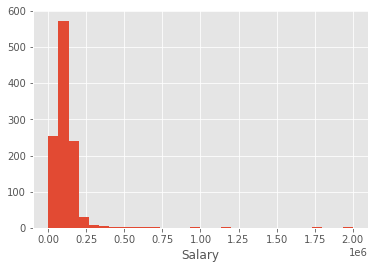

In [5]:
plt.hist(SALARIES, bins=30)
plt.xlabel('Salary')

There are a few outliers, and they're making it hard to see the shape of the distribution. If -- just for the plot -- we remove the salaries above $500,000, we see get a clearer picture:

Text(0.5, 0, 'Salary')

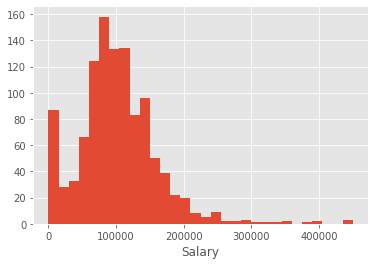

In [6]:
plt.hist(SALARIES[SALARIES < 500_000], bins=30)
plt.xlabel('Salary')

It looks like the "center" of the distribution is around $100,000. In fact, the mean is:

In [7]:
np.mean(SALARIES)

110636.47280999109

and the median is:

In [8]:
np.median(SALARIES)

100000.0

## 3. Example: Minimizing the mean squared error

Let's make our first prediction by minimizing the mean squared error.

Recall that the square loss is $L_\text{sq}(h,y) = (h-y)^2$. Given a data set of numbers, $y_1, \ldots, y_n$, the **risk** associated with this loss is:
$$
    R_\text{sq}(h) = \frac1n \sum_{i=1}^n L_\text{sq}(h,y_i)
    =
    \frac1n \sum_{i=1}^n (h - y_i)^2
$$
When the square loss is used, the risk is also known as the **mean squared error**. We saw in lecture that the mean squared error is directly minimized by the **mean**.

But we can also minimize the mean squared error with gradient descent. Why would we do this, given that we have a nice, simple formula for the minimizer? In truth, we wouldn't. But in coming weeks we will see situations where we also have a formula for the minimizer, but we decide to use gradient descent instead. In those situations, it turns out that gradient descent is computationally faster.

To begin, let's plot the mean squared error (MSE) for a range of predictions. We start by defining a function that computes the MSE for any possible prediction.

In [9]:
@np.vectorize
def mean_squared_error(h):
    return np.mean((SALARIES - h)**2)

For example, the MSE of predicting $h = \$100{,}000$ is:

In [10]:
mean_squared_error(100_000)

array(1.21230714e+10)

We'll evaluate the MSE on each of 1,000 possible predictions, from $\$25{,}000$ to $\$200{,}000$, and plot the risk.
We'll also include the histogram of the data in the background so that we can see how the MSE relates to the data's distribution.

In [11]:
possible_predictions = np.linspace(25_000, 200_000, 1_000)

In [12]:
def plot_risk_and_histogram(risk):
    fig, ax1 = plt.subplots()

    ax1.hist(SALARIES[SALARIES<300_000], bins=20, alpha=.5, zorder=1)

    ax2 = ax1.twinx()
    ax2.grid(False)
    ax2.plot(possible_predictions, risk(possible_predictions), color='black', zorder=20)
    plt.xlabel('Prediction')
    plt.ylabel('MSE')

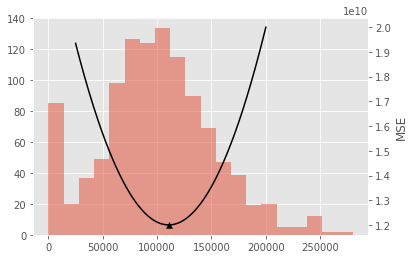

In [13]:
plot_risk_and_histogram(mean_squared_error)
plt.scatter(np.mean(SALARIES), mean_squared_error(np.mean(SALARIES)), color='black', marker='^')

The mean of the salaries is shown as the black triangle. As we expected, the minimizer of the mean squared error is indeed the mean. But instead of computing the mean directly, let's minimize this function using gradient descent.

To do so, we need a function which returns the derivative of $R_\text{sq}$ at any given place. Recall that the derivative of $R_\text{sq}$ with respect to $h$ is:

$$
    \frac{dR_\text{sq}}{dh}(h)
    =
    \frac{2}{n}
    \sum_{i=1}^n
        (h - y_i)
$$

Let's code this up:

In [14]:
@np.vectorize
def derivative_of_mean_squared_error(h):
    return 2 * np.mean(h - SALARIES)

Now we can calculate the derivative of the MSE at any point:

In [15]:
derivative_of_mean_squared_error(100_000)

array(-21272.94561998)

To check that we got the derivative right, we can check that it gives the right slope. The cell below defined a couple of helper functions which use `derivative_of_mean_squared_error` to plot the tangent line the the MSE at any point we choose. If the derivative is correct, we should see a line that is indeed tangent to the MSE:

In [19]:
from utils import plot_tangent_line

In [20]:
plot_tangent_line(
    f=mean_squared_error,
    f_prime=derivative_of_mean_squared_error,
    interval_size=30_000,
    domain=possible_predictions
)

interactive(children=(FloatSlider(value=25000.0, continuous_update=False, description='h', max=200000.0, min=2…

<function utils.plot_tangent_line.<locals>.plot(h)>

Looks good! We know have everything we need to run gradient descent. We'll start with a step size of $\alpha = .1$, and we'll use $h_0 = 60{,}000$ as our starting position:

In [21]:
gradient_descent(
    derivative_of_mean_squared_error,
    h_0=60_000,
    alpha=.1,
    verbose=True,
    tol=.001,
)

iter #0: h=70127.29456199822
iter #1: h=78229.13021159678
iter #2: h=84710.59873127565
iter #3: h=89895.77354701873
iter #4: h=94043.9133996132
iter #5: h=97362.42528168877
iter #6: h=100017.23478734924
iter #7: h=102141.0823918776
iter #8: h=103840.16047550029
iter #9: h=105199.42294239845
iter #10: h=106286.83291591698
iter #11: h=107156.7608947318
iter #12: h=107852.70327778364
iter #13: h=108409.45718422513
iter #14: h=108854.86030937832
iter #15: h=109211.18280950087
iter #16: h=109496.24080959891
iter #17: h=109724.28720967734
iter #18: h=109906.72432974009
iter #19: h=110052.67402579029
iter #20: h=110169.43378263044
iter #21: h=110262.84158810257
iter #22: h=110337.56783248027
iter #23: h=110397.34882798244
iter #24: h=110445.17362438417
iter #25: h=110483.43346150556
iter #26: h=110514.04133120266
iter #27: h=110538.52762696035
iter #28: h=110558.1166635665
iter #29: h=110573.78789285141
iter #30: h=110586.32487627935
iter #31: h=110596.3544630217
iter #32: h=110604.3781324155

110636.46854387668

This is pretty close to the mean:

In [22]:
np.mean(SALARIES)

110636.47280999109

If we let gradient descent run for even longer it would get arbitrarily close to the mean. So we have successfully computed the mean without using the formula for the mean.

Let's visualize the progress of gradient descent. The code to make the visualization is somewhat long and besides the point, so I've put it in a utility module:

In [23]:
from utils import visualize_gradient_descent

The visualization below is an animation. The current position of gradient descent is shown as a black dot. The arrow shows the update step -- it's length is exactly $-\alpha \frac{dR}{dh}(h)$. The dashed line is the tangent line, and the blue dot is the new position after updating:

In [25]:
visualize_gradient_descent(
    f=mean_squared_error,
    derivative_of_f=derivative_of_mean_squared_error,
    h_0=60_000,
    alpha=.1,
    n_iters=10,
    interval_size=15_000,
    domain=np.linspace(50_000, 175_000)
)

/Users/palvins/Desktop/dsc40a/dsc40a-demos/01-gradient_descent/utils.py:67: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  current_ln, = ax.plot(h, [f(h[0])], 'ro', color='black')


Let's try a bigger step size of $\alpha=.25$.

In [26]:
visualize_gradient_descent(
    f=mean_squared_error,
    derivative_of_f=derivative_of_mean_squared_error,
    h_0=60_000,
    alpha=.25,
    n_iters=10,
    interval_size=15_000,
    domain=np.linspace(50_000, 175_000)
)

/Users/palvins/Desktop/dsc40a/dsc40a-demos/01-gradient_descent/utils.py:67: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  current_ln, = ax.plot(h, [f(h[0])], 'ro', color='black')


It looks like we converge even faster. How about if we use a step size of $\alpha = 1.5?$

In [27]:
visualize_gradient_descent(
    f=mean_squared_error,
    derivative_of_f=derivative_of_mean_squared_error,
    h_0=60_000,
    alpha=1.1,
    n_iters=6,
    interval_size=15_000,
    domain=np.linspace(-40_000, 250_000)
)

/Users/palvins/Desktop/dsc40a/dsc40a-demos/01-gradient_descent/utils.py:67: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  current_ln, = ax.plot(h, [f(h[0])], 'ro', color='black')


Gradient descent appears to diverge! This suggests that we must strike a balance when choosing the step size: too small and it will take a long time to converge. Too big, and we might diverge.

## 3. Example: Minimizing the mean UCSD loss

In lecture, we designed our own loss function, which we called $L_\text{ucsd}$:

$$
    L_\text{ucsd}(h,y) = 1 - e^{-(h-y)^2 / \sigma^2}
$$

Here, $\sigma$ is a **scale parameter**; it determines what is considered to be an outlier. We can use this loss to make a prediction by minimizing the risk:

$$
R_\text{ucsd}(h) 
= 
\frac{1}{n} \sum_{i=1}^n L_\text{ucsd}(h, y_i)
=
\frac{1}{n} \sum_{i=1}^n \left(1 - e^{-(h-y_i)^2 / \sigma^2}\right)
$$

In class, we tried to do so by taking a derivative, setting to zero, and solving. The function was differentiable,
with derivative:

$$
\frac{dR_\text{ucsd}}{dh}(h)
=
\frac{2}{n\sigma^2} \sum_{i=1}^n (h- y_i) e^{-(h - y_i)^2/\sigma^2}
$$

But when we went to solve this for $h$, we got stuck. Let's try to use gradient descent to minimize it.

To begin, let's plot $R_\text{ucsd}$. To do so, we first have to choose the value of the scale parameter, $\sigma$. We'll work with three particular choices: $\sigma_1 = 7500$, $\sigma_2 = 10000$, and $\sigma_3 = 30000$.

In [28]:
def make_ucsd_risk(sigma):
    @np.vectorize
    def ucsd_risk(h):
        return (1 - np.exp(-(h - SALARIES)**2 / sigma**2)).mean()
    return ucsd_risk

ucsd_risk_7_500 = make_ucsd_risk(7_500)
ucsd_risk_10_000 = make_ucsd_risk(10_000)
ucsd_risk_30_000 = make_ucsd_risk(30_000)

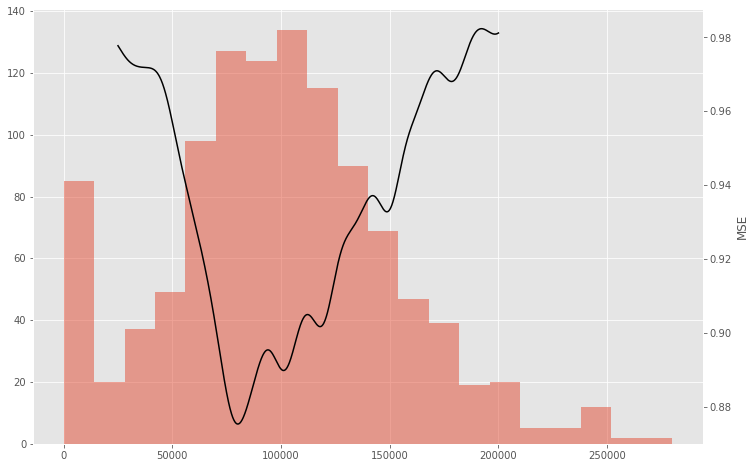

In [29]:
plot_risk_and_histogram(ucsd_risk_7_500)

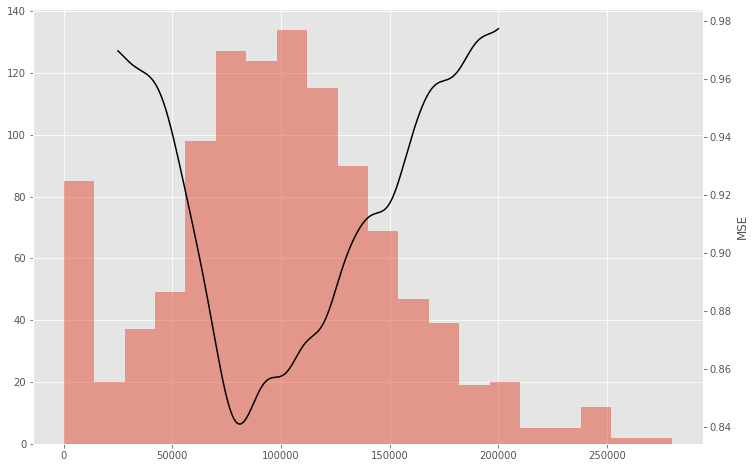

In [30]:
plot_risk_and_histogram(ucsd_risk_10_000)

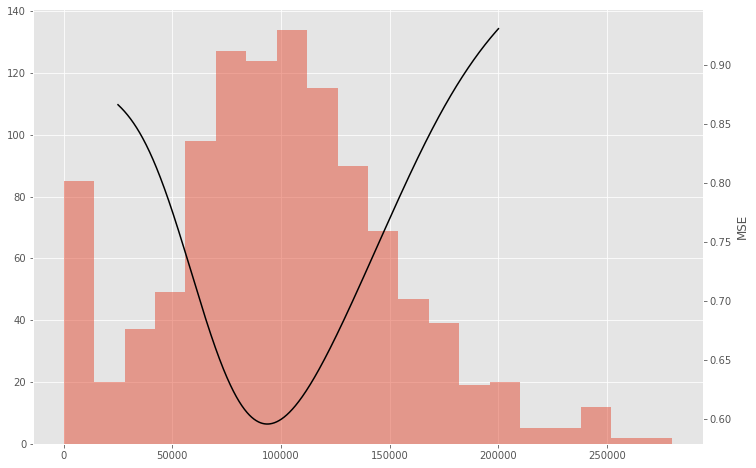

In [31]:
plot_risk_and_histogram(ucsd_risk_30_000)

To run gradient descent, we need to define a function that computes the derivative for any value of $h$. Again, we'll need a function for each choice of scale parameter:

In [32]:
def make_derivative_of_ucsd_risk(sigma):
    @np.vectorize
    def derivative_of_ucsd_risk(h):
        return ((h - SALARIES) * np.exp(-(h - SALARIES)**2 / sigma**2)).mean() * (2/sigma**2)
    return derivative_of_ucsd_risk

derivative_of_ucsd_risk_7_500 = make_derivative_of_ucsd_risk(7_500)
derivative_of_ucsd_risk_10_000 = make_derivative_of_ucsd_risk(10_000)
derivative_of_ucsd_risk_30_000 = make_derivative_of_ucsd_risk(30_000)

In [33]:
plot_tangent_line(
    f=ucsd_risk_7_500,
    f_prime=derivative_of_ucsd_risk_7_500,
    interval_size=30_000,
    domain=possible_predictions
)

interactive(children=(FloatSlider(value=25000.0, continuous_update=False, description='h', max=200000.0, min=2…

<function utils.plot_tangent_line.<locals>.plot(h)>

We have everything we need to run gradient descent. Let's start with $\sigma = 30{,}000$, and use a step size of $\alpha = 0.1$; this worked well with the MSE:

In [34]:
visualize_gradient_descent(
    f=ucsd_risk_30_000,
    derivative_of_f=derivative_of_ucsd_risk_30_000,
    h_0=140_000,
    alpha=.1,
    n_iters=10,
    interval_size=15_000,
    domain=np.linspace(25_000, 175_000, 1_000)
)

/Users/palvins/Desktop/dsc40a/dsc40a-demos/01-gradient_descent/utils.py:67: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  current_ln, = ax.plot(h, [f(h[0])], 'ro', color='black')


It looks like it isn't working. What could be wrong?

### Discussion question

What is the most likely reason that gradient descent appears to be stuck?

- a) our calculated derivative is wrong
- b) we have used a bad starting location
- c) we have chosen a bad step size
- d) our formula for the risk is wrong

### Answer

Look at the scale of the axes. Here, the horizontal axis is on the order of 100,000, while the vertical axis is on the order of 1. This means that a change in the prediction of one dollar only increases or decreases the risk by a small amount. Before, with the MSE, the scale of the horizontal axis was the same, but the scale of the vertical axis was on the order of tens of billions. A change of one dollar caused the MSE to increase by a lot.

This is supported by the derivitaves:

In [35]:
derivative_of_ucsd_risk_30_000(140_000)

array(4.10455384e-06)

In [36]:
derivative_of_mean_squared_error(140_000)

array(58727.05438002)

Remember that since the update is $\alpha \times (\text{the derivative at $h$})$. Since the derivative is so small, we need to increase the step size to compensate. If we want to make a step of about 5,000 dollars, then we should take $\alpha$ to be:

$$
\alpha = 5{,}000 / (\text{derivative at $h$}) = 5{,}000 / (4 \times 10^{-6}) \approx 2 \text{ billion}
$$

Let's try it:

In [37]:
visualize_gradient_descent(
    f=ucsd_risk_30_000,
    derivative_of_f=derivative_of_ucsd_risk_30_000,
    h_0=140_000,
    alpha=2e9,
    n_iters=10,
    interval_size=15_000,
    domain=np.linspace(25_000, 175_000, 1000)
)

/Users/palvins/Desktop/dsc40a/dsc40a-demos/01-gradient_descent/utils.py:67: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  current_ln, = ax.plot(h, [f(h[0])], 'ro', color='black')


Now let's try $\sigma = 7{,}500$:

In [38]:
visualize_gradient_descent(
    f=ucsd_risk_7_500,
    derivative_of_f=derivative_of_ucsd_risk_7_500,
    h_0=140_000,
    alpha=2e9,
    n_iters=10,
    interval_size=15_000,
    domain=np.linspace(40_000, 160_000, 1000),
    arrow_height=.001
)

/Users/palvins/Desktop/dsc40a/dsc40a-demos/01-gradient_descent/utils.py:67: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  current_ln, = ax.plot(h, [f(h[0])], 'ro', color='black')


We have converged to a **local minimum**! That's not quite what we wanted. What if we use a larger step size?

In [39]:
visualize_gradient_descent(
    f=ucsd_risk_7_500,
    derivative_of_f=derivative_of_ucsd_risk_7_500,
    h_0=140_000,
    alpha=7e9,
    n_iters=20,
    interval_size=15_000,
    domain=np.linspace(40_000, 160_000, 1000),
    arrow_height=.001
)

/Users/palvins/Desktop/dsc40a/dsc40a-demos/01-gradient_descent/utils.py:67: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  current_ln, = ax.plot(h, [f(h[0])], 'ro', color='black')


We're bouncing around again! It is really hard to pick a step size that works when the function looks like this (there may not be one!)

However, suppose we had started at $h_0 = 60{,}000$ instead of $h_0 = 140{,}000$:

In [40]:
visualize_gradient_descent(
    f=ucsd_risk_7_500,
    derivative_of_f=derivative_of_ucsd_risk_7_500,
    h_0=60_000,
    alpha=2e9,
    n_iters=20,
    interval_size=15_000,
    domain=np.linspace(40_000, 160_000, 1000),
    arrow_height=.001
)

/Users/palvins/Desktop/dsc40a/dsc40a-demos/01-gradient_descent/utils.py:67: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  current_ln, = ax.plot(h, [f(h[0])], 'ro', color='black')


It looks to have worked. Choosing different starting locations and running gradient descent a bunch of times is an actual strategy that people use to find the global minimum of a function with a bunch of local minima.

Now let's look at the risk with $\sigma = 10{,}000$:

In [41]:
visualize_gradient_descent(
    f=ucsd_risk_10_000,
    derivative_of_f=derivative_of_ucsd_risk_10_000,
    h_0=140_000,
    alpha=4e9,
    n_iters=50,
    interval_size=15_000,
    domain=np.linspace(40_000, 160_000, 1000),
    arrow_height=.001
)

/Users/palvins/Desktop/dsc40a/dsc40a-demos/01-gradient_descent/utils.py:67: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  current_ln, = ax.plot(h, [f(h[0])], 'ro', color='black')


It looks to have worked, though it slowed down a bit when the function was flat. This is another difficulty with gradient descent: if the search enters a region where the function is near flat, it will slow down.